BAYESIAN NEURAL NETWORK PREDICT PRICE DOG-COIN

In [2]:
!pip install blitz
!pip install blitz-bayesian-pytorch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for blitz: filename=blitz-0.3.3-py3-none-any.whl size=7249 sha256=cfe564efc6a916c99fb0068a1e710d9e97478bfd525a172c029fb0dbe2ac3bd1
  Stored in directory: /root/.cache/pip/wheels/2c/64/41/ddc70b2e23e810f1f7e2f9c34ed06bde65b1a45ce4fe5acb27
Successfully built blitz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.2 MB/s eta 0:00:00


IMPORT PAKAGES

In [84]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#from blitz.modules.base_bayesian_module import BayesianModule, BayesianRNN, BayesianLSTM
from blitz.modules import BayesianLSTM
from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

import yfinance as yf
from google.colab import drive
drive.mount('/content/drive')
from keras.models import Sequential
from keras.layers import Dense, LSTM

plt.rcParams.update({'figure.figsize':(13,10)})
plt.rcParams.update({'font.size':20})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:

df = pd.read_csv('/content/drive/MyDrive/DOGE-USD.csv')
df1=df.reset_index()['Close']

In [76]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [107]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [109]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [110]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [111]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [112]:
# 8. Define BAYESIAN NN Model

@variational_estimator
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.lstm_1 = BayesianLSTM(1, 10, prior_sigma_1=1, prior_pi=1, posterior_rho_init=-3.0)
        self.linear = nn.Linear(10, 1)
            
    def forward(self, x):
        x_, _ = self.lstm_1(x)
        
        #gathering only the latent end-of-sequence for the linear layer
        x_ = x_[:, -1, :]
        x_ = self.linear(x_)
        return x_

In [113]:
#Conduct Bayesian Neural Networks with LSTM Architecture
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 7s 187ms/step - loss: 0.0135 - val_loss: 0.0837
Epoch 2/100
14/14 [==============================] - 2s 123ms/step - loss: 0.0024 - val_loss: 0.0056
Epoch 3/100
14/14 [==============================] - 2s 124ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 4/100
14/14 [==============================] - 2s 122ms/step - loss: 8.3896e-04 - val_loss: 0.0027
Epoch 5/100
14/14 [==============================] - 2s 131ms/step - loss: 7.9234e-04 - val_loss: 0.0026
Epoch 6/100
14/14 [==============================] - 3s 189ms/step - loss: 6.9547e-04 - val_loss: 0.0023
Epoch 7/100
14/14 [==============================] - 2s 126ms/step - loss: 6.4751e-04 - val_loss: 0.0024
Epoch 8/100
14/14 [==============================] - 2s 126ms/step - loss: 6.0689e-04 - val_loss: 0.0022
Epoch 9/100
14/14 [==============================] - 2s 167ms/step - loss: 5.7979e-04 - val_loss: 0.0022
Epoch 10/100
14/14 [==============================] - 3s 211ms/step

In [114]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 28ms/step


In [115]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [116]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 141.45415219422455
Testing RMSE: 137.13041234480468


In [117]:
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.7688752]
101
1 day input [0.75477932 0.76118431 0.74641359 0.70255877 0.68955262 0.67556615
 0.6751087  0.69569623 0.67465115 0.67223296 0.66027256 0.63419499
 0.65752756 0.65961894 0.62785532 0.63628642 0.62752851 0.65759288
 0.66105681 0.66484755 0.68288624 0.68236337 0.69118655 0.69889877
 0.69412771 0.69451984 0.71151269 0.73268851 0.74196924 0.73759031
 0.75131539 0.76419069 0.74504104 0.75347209 0.76092283 0.79615053
 0.82020198 0.80209797 0.8211823  0.80333978 0.79647724 0.79739224
 0.8159538  0.81170551 0.82562666 0.8150388  0.80745732 0.78085684
 0.78366725 0.7868697  0.76928866 0.77719684 0.77386365 0.76013857
 0.76406005 0.79752298 0.81582305 0.80124839 0.80954871 0.79464724
 0.78098758 0.79386298 0.80771871 0.81033306 0.82902527 0.82346985
 0.83915557 0.85144279 0.84196599 0.84915524 0.85778246 0.84490705
 0.84078951 0.86118107 0.87157286 0.88817358 0.89647399 0.89294474
 0.88072285 0.88660507 0.86941606 0.86137713 0.85680214 0.89248719
 0.89019974 0.89033039 0.89843473 

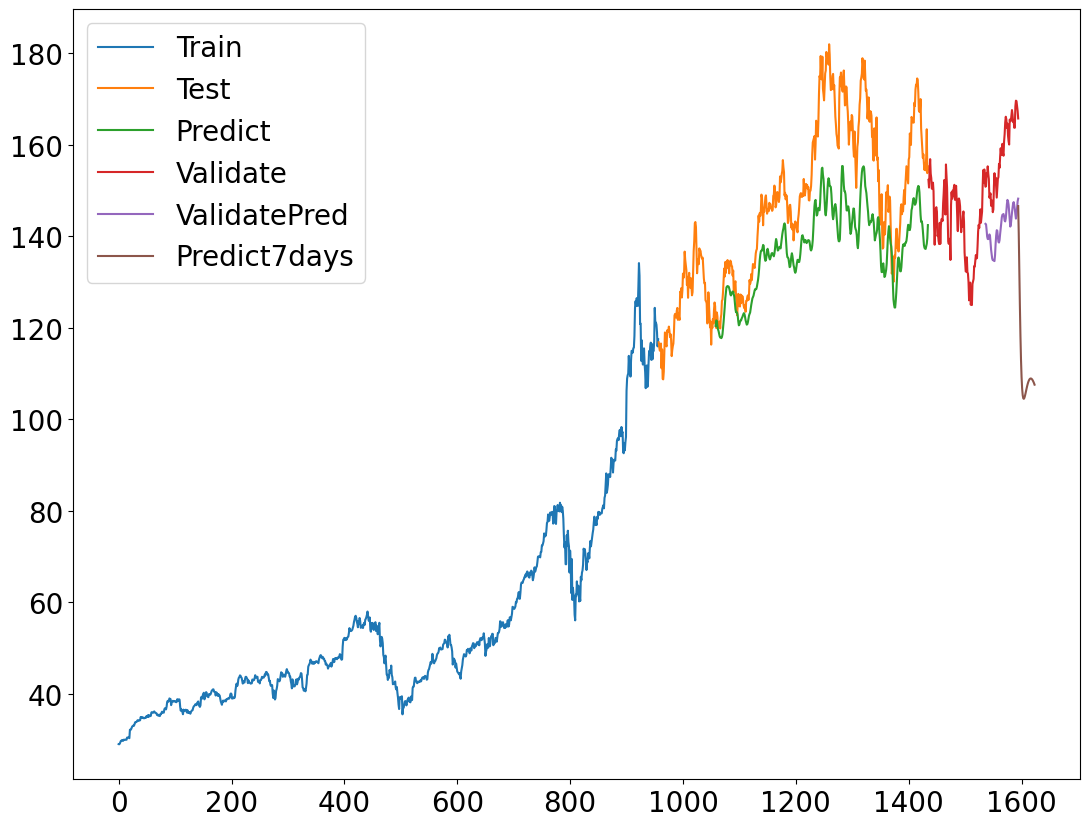

In [118]:
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29 , step=1) 
#prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+6 , step=1) #7
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
#plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict7days'])
plt.show()

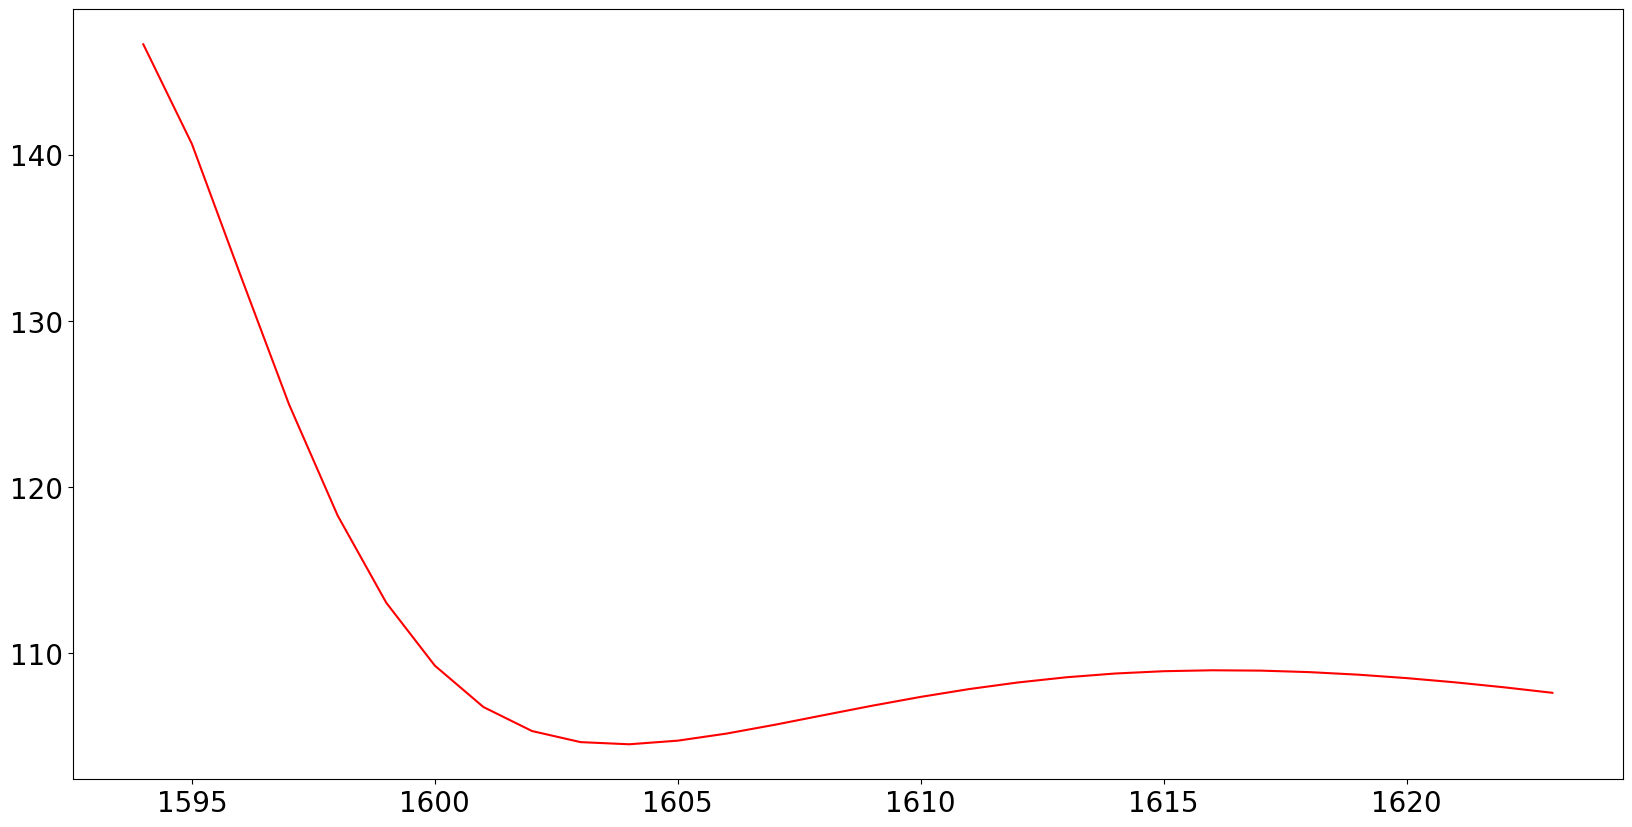

In [120]:
plt.figure(figsize=(20,10))
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output), c='r', label='Next 30 days')
#plt.plot(prediect_data_index,scaler.inverse_transform(lst_output), c='r', label='Next 7 days')
plt.show()